In [ ]:
# @title Importing Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import random
import re
import string
import collections
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.callbacks import ModelCheckpoint
# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

**Read Data**

In [ ]:
tr_data = pd.read_csv('/content/training.csv')
test_data = pd.read_csv('/content/test.csv')
validation_data = pd.read_csv('/content/validation.csv')

### **PreProcessing**

In [ ]:
tr_data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Data doesn't have any null

In [ ]:
tr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [ ]:
tr_data.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [ ]:
tr_data.shape[0]

16000

We have one duplicate row that needs removal

In [ ]:
print("Duplicate entries in the dataset: " + str(tr_data.duplicated().sum()))

Duplicate entries in the dataset: 1


In [ ]:
tr_data.drop_duplicates(inplace=True)

In [ ]:
print("Duplicate entries in the dataset: " + str(tr_data.duplicated().sum()))

Duplicate entries in the dataset: 0


Map each label for encoding.

In [ ]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
tr_data['description'] = tr_data['label'].map(labels_dict )
tr_data.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
tr_data.groupby(["description","label"]).size()

description  label
anger        3        2159
fear         4        1937
joy          1        5361
love         2        1304
sadness      0        4666
surprise     5         572
dtype: int64

<Axes: xlabel='description', ylabel='count'>

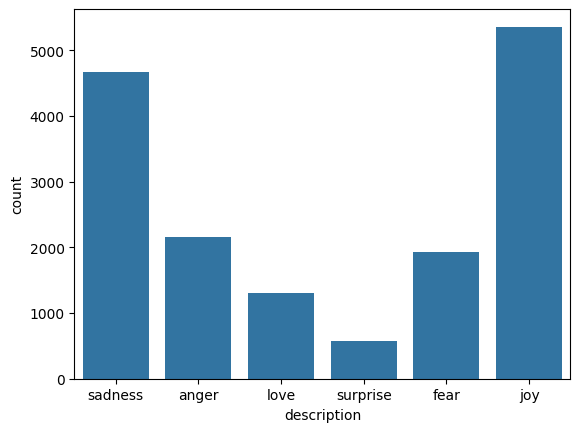

In [ ]:
sns.countplot(x='description',data=tr_data)

Joy dominates the data with its highest frequency, while surprise barely registers with the lowest count.

In [ ]:
tr_data.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re

stemmer = PorterStemmer()


def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert to lowercase and split into words
    words = text.lower().split()

    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # words_stemmed = [stemmer.stem(word) for word in words if word not in stop_words]


    # Join the words back into a single string
    return ' '.join(words)


In preprocessing, we initially remove non-alphabetic characters, then convert the text to lowercase, and finally apply lemmatization to extract the core meanings from the sentences.

Here we apply preprocessing on data

In [ ]:
tr_data['Clean Text']=tr_data['text'].apply(preprocess_text)
test_data['Clean Text']=test_data['text'].apply(preprocess_text)
validation_data['Clean Text']=validation_data['text'].apply(preprocess_text)

In [ ]:
tr_data.head()

,text,label,description,Clean Text
0,i didnt feel humiliated,0,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,anger,feeling grouchy


We utilize TF-IDF vectorization to identify words with significant impact in the data, assigning them higher values based on their frequency and importance

In [ ]:
# Install necessary packages if you haven't already
# !pip install pandas scikit-learn

# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TfidfVectorizer with hyperparameters
tfidf_vectorizer = TfidfVectorizer(max_features=10000,max_df=0.1,ngram_range=(1,2), stop_words='english')

# Fit and transform the training data
x_train = tfidf_vectorizer.fit_transform(tr_data['Clean Text'])

# Transform the validation and test data
x_val = tfidf_vectorizer.transform(validation_data['Clean Text'])
x_test = tfidf_vectorizer.transform(test_data['Clean Text'])

# Convert the sparse matrices to dense format
x_train_dense_tfidf = x_train.toarray()
x_val_dense_tfidf = x_val.toarray()
x_test_dense_tfidf = x_test.toarray()


In [ ]:
tr_data.shape

(15999, 4)

In [ ]:
tr_data.shape[1]

4

### ٍ**Model**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Create the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(x_train_dense_tfidf, tr_data['label'])

# Make predictions on the test data
predictions_train = log_reg.predict(x_train_dense_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(tr_data['label'], predictions_train))
# print("\nClassification Report:\n", classification_report(test_data['label'], predictions))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9553722107631727


In [ ]:
predictions_val = log_reg.predict(x_val_dense_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(validation_data['label'], predictions_val))


Accuracy: 0.892


In [ ]:
predictions_test = log_reg.predict(x_test_dense_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(test_data['label'], predictions_test))


Accuracy: 0.8885


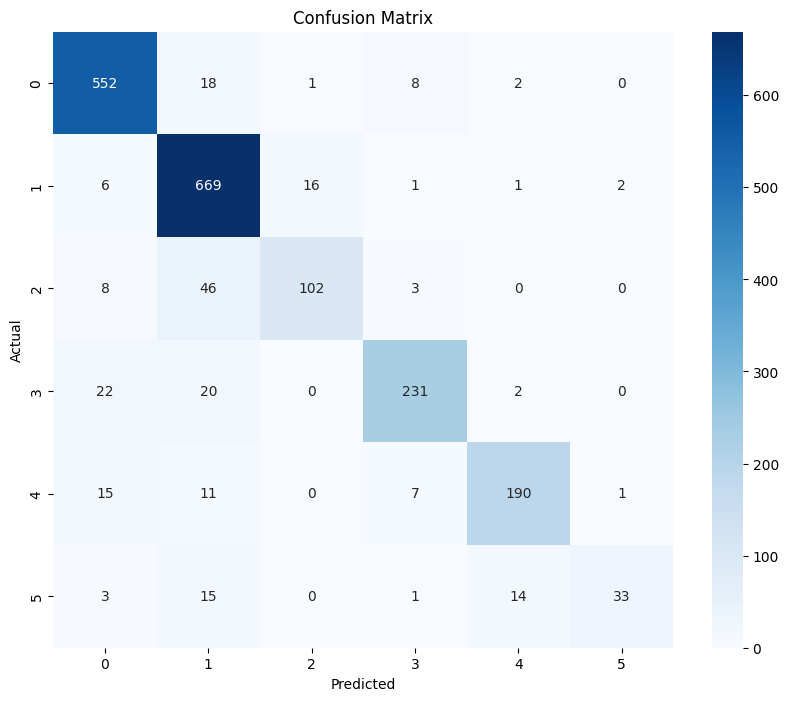

In [ ]:
# Compute confusion matrix
cm_raw = confusion_matrix(test_data['label'], predictions_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=70,max_depth=5, random_state=42)
rf_model.fit(x_train_dense_tfidf, tr_data['label'])

# Predict on the train set
tr_y_pred = rf_model.predict(x_train_dense_tfidf)

# Generate classification report for Random Forest
rf_report = classification_report(tr_data['label'], tr_y_pred)
print("Random Forest Classification Report:")
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.02      0.04      4666
           1       0.34      1.00      0.50      5361
           2       0.00      0.00      0.00      1304
           3       0.00      0.00      0.00      2159
           4       0.00      0.00      0.00      1937
           5       0.00      0.00      0.00       572

    accuracy                           0.34     15999
   macro avg       0.22      0.17      0.09     15999
weighted avg       0.40      0.34      0.18     15999



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred_val = rf_model.predict(x_val_dense_tfidf)
val_accuracy = accuracy_score(validation_data['label'], y_pred_val)
print("Validation Accuracy:", val_accuracy)


Validation Accuracy: 0.359


In [ ]:
y_pre_test = rf_model.predict(x_test_dense_tfidf)
test_accuracy = accuracy_score(test_data['label'], y_pre_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.3525


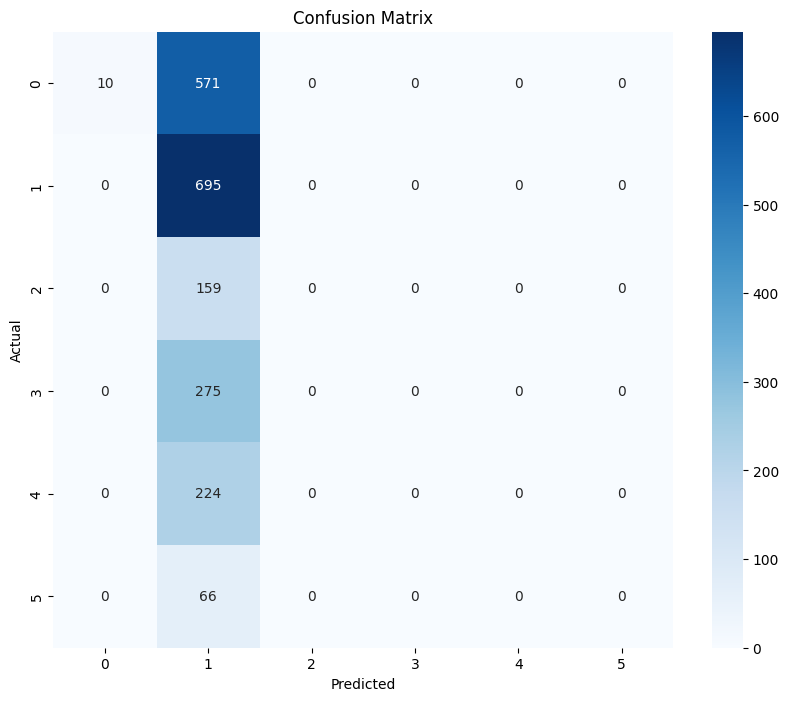

In [ ]:
# Compute confusion matrix
cm_raw = confusion_matrix(test_data['label'], y_pre_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Import the SVM classifier
from sklearn.svm import SVC
# Evaluate the performance on the validation set
from sklearn.metrics import accuracy_score


# Create the SVM model
svm_classifier = SVC(kernel='linear')

# Train the model using the training data
svm_classifier.fit(x_train_dense_tfidf, tr_data['label'])


SVC(kernel='linear')

In [ ]:
y_pred_train = svm_classifier.predict(x_train_dense_tfidf)
train_accuracy = accuracy_score(tr_data['label'], y_pred_train)
print("Train Accuracy:", train_accuracy)


Train Accuracy: 0.9659978748671793


In [ ]:
y_pred_val = svm_classifier.predict(x_val_dense_tfidf)
val_accuracy = accuracy_score(validation_data['label'], y_pred_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9035


In [ ]:
y_test_val = svm_classifier.predict(x_test_dense_tfidf)
test_accuracy = accuracy_score(test_data['label'], y_test_val)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8965


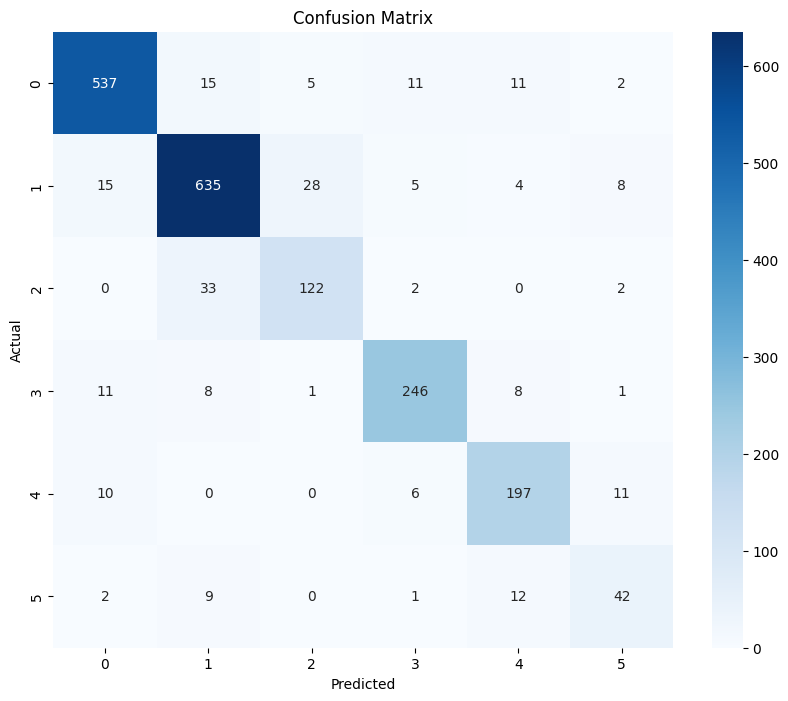

In [ ]:
# Compute confusion matrix
cm_raw = confusion_matrix(test_data['label'], y_pre_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import joblib

In [ ]:
joblib.dump(svm_classifier,'SVM_LINEAR.joblib')

['SVM_LINEAR.joblib']

In [ ]:
joblib.dump(log_reg,'LogisticRegression.joblib')

['LogisticRegression.joblib']

In [ ]:
joblib.dump(tfidf_vectorizer,'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']